In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Challenge: Evaluate Naive Bayes Classifiers

Dataset: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

### Task
Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

* Do any of your classifiers seem to overfit?
* Which seem to perform the best? Why?
* Which features seemed to be most impactful to performance?
Write up your iterations and answers to the above questions in a few pages. 

In [2]:
# Grab and process the raw data.
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']

amazon_raw.describe()

,score
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### the Amazon dataset

#### Iteration 0 - Baseline

In [4]:
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love',
            'recommend',
            'perfect',
            'Unreliable',
            'unreliable',
            'happy',
            'unhappy',
            'best',
            'excelent',
            'Excelent',
            'nice',
            'fine']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
amazon_bnb = BernoulliNB()

# Fit our model to the data.
amazon_bnb.fit(amazon_data, amazon_target)

# Classify, storing the result in a new variable.
amazon_y_pred = amazon_bnb.predict(amazon_data)

## Model Evaluation

#### There is no class inbalance between negative and positive

Confusion matrix, without normalization
[[468  32]
 [225 275]]


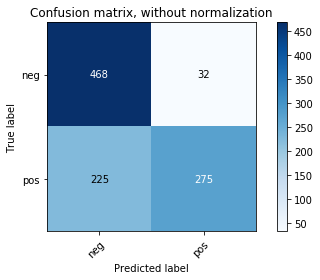

Accuracy:  0.743
Precision:  0.8957654723127035
Recall:  0.55
Average precision-recall score: 0.72


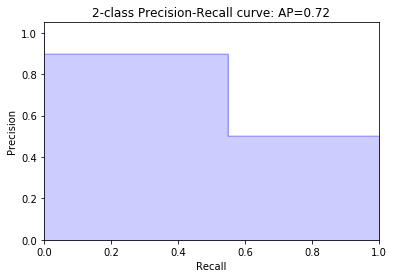

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import average_precision_score, precision_score, recall_score, accuracy_score, confusion_matrix
plot_confusion_matrix(amazon_target, amazon_y_pred,  np.array(['neg', 'pos']))
plt.show()
print("Accuracy: ", accuracy_score(amazon_target, amazon_y_pred))
print("Precision: ", precision_score(amazon_target, amazon_y_pred))
print("Recall: ", recall_score(amazon_target, amazon_y_pred))

average_precision = average_precision_score(amazon_target, amazon_y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(amazon_target, amazon_y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

#### Holdout method:

In [6]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(amazon_data, amazon_target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(amazon_bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(amazon_bnb.fit(amazon_data, amazon_target).score(amazon_data, amazon_target)))

With 20% Holdout: 0.735
Testing on Sample: 0.743


In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(amazon_bnb, amazon_data, amazon_target, cv=10)

array([0.81, 0.76, 0.82, 0.7 , 0.76, 0.72, 0.69, 0.67, 0.78, 0.66])

#### Iteration 1 - More Keywords

Confusion matrix, without normalization
[[468  32]
 [225 275]]


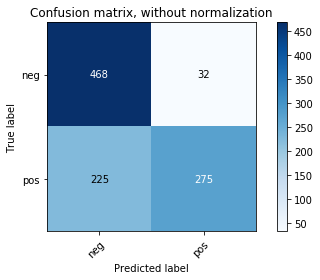

Accuracy:  0.743
Precision:  0.8957654723127035
Recall:  0.55


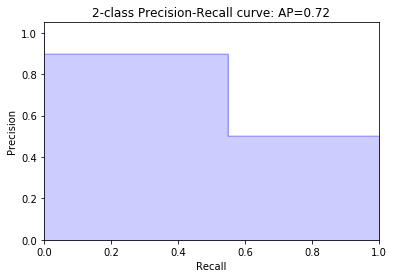

With 20% Holdout: 0.735
Testing on Sample: 0.743


In [8]:
# Reset
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love',
            'recommend',
            'perfect',
            'Unreliable',
            'unreliable',
            'happy',
            'unhappy',
            'best',
            'excelent',
            'Excelent',
            'nice',
            'fine',
            'loved',
            'unacceptible',
            'negative',
            'fun',
            'best',
            'worst',
            'disapoinment',
            'favorite',
            'mistake']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

# Instantiate our model and store it in a new variable.
amazon_bnb = BernoulliNB()

# Fit our model to the data.
amazon_bnb.fit(amazon_data, amazon_target)

# Classify, storing the result in a new variable.
amazon_y_pred = amazon_bnb.predict(amazon_data)

plot_confusion_matrix(amazon_target, amazon_y_pred,  np.array(['neg', 'pos']))
plt.show()
print("Accuracy: ", accuracy_score(amazon_target, amazon_y_pred))
print("Precision: ", precision_score(amazon_target, amazon_y_pred))
print("Recall: ", recall_score(amazon_target, amazon_y_pred))


precision, recall, _ = precision_recall_curve(amazon_target, amazon_y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Test your model with different holdout groups.
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(amazon_data, amazon_target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(amazon_bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(amazon_bnb.fit(amazon_data, amazon_target).score(amazon_data, amazon_target)))

Even with more keywords no metric has changed for the better. 

#### Iteration 2 - More Keywords
Because all the new keywords are worthless features, we can get rid of them. 
But keep in mind, if you get more data these worthless features can become valuable again. 

In [9]:
# Reset
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love',
            'recommend',
            'perfect',
            'Unreliable',
            'unreliable',
            'happy',
            'unhappy',
            'best',
            'excelent',
            'Excelent',
            'nice',
            'fine']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

#### Iteration 3 - Better Keywords
Get rid of some more keywords which won't contribute for a better model performance.

Confusion matrix, without normalization
[[474  26]
 [241 259]]


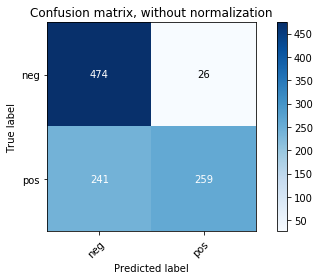

Accuracy:  0.733
Precision:  0.9087719298245615
Recall:  0.518


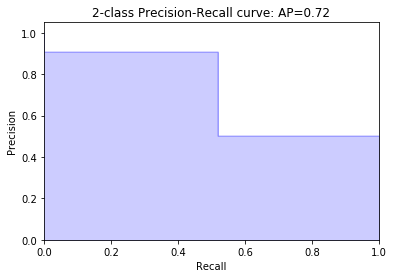

With 20% Holdout: 0.715
Testing on Sample: 0.733


In [10]:
# Reset
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love', # helps
            #'recommend', precsion gets better, recall gets worse
            'perfect', # helps
            #'Unreliable', # is not helping
            #'unreliable', # is not helping
            'happy',
            'unhappy', # helps
            'best', # helps
            'excelent', # helps a tiny bit
            'Excelent', # helps a tiny bit
            'nice', # helps
            'fine'] # helps

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

# Instantiate our model and store it in a new variable.
amazon_bnb = BernoulliNB()

# Fit our model to the data.
amazon_bnb.fit(amazon_data, amazon_target)

# Classify, storing the result in a new variable.
amazon_y_pred = amazon_bnb.predict(amazon_data)

plot_confusion_matrix(amazon_target, amazon_y_pred,  np.array(['neg', 'pos']))
plt.show()
print("Accuracy: ", accuracy_score(amazon_target, amazon_y_pred))
print("Precision: ", precision_score(amazon_target, amazon_y_pred))
print("Recall: ", recall_score(amazon_target, amazon_y_pred))


precision, recall, _ = precision_recall_curve(amazon_target, amazon_y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Test your model with different holdout groups.
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(amazon_data, amazon_target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(amazon_bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(amazon_bnb.fit(amazon_data, amazon_target).score(amazon_data, amazon_target)))

#### Iteration 4 - other Naive Bayes type
1. GaussianNB
2. MultinomialNB

Confusion matrix, without normalization
[[474  26]
 [241 259]]


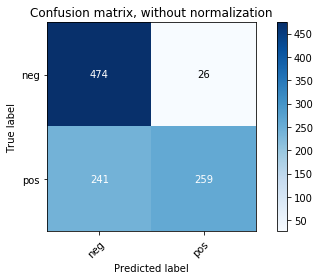

Accuracy:  0.733
Precision:  0.9087719298245615
Recall:  0.518


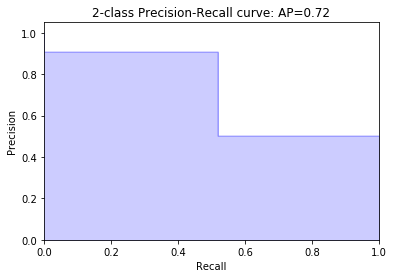

With 20% Holdout: 0.715
Testing on Sample: 0.733


In [11]:
# Reset
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love', # helps
            #'recommend', precsion gets better, recall gets worse
            'perfect', # helps
            #'Unreliable', # is not helping
            #'unreliable', # is not helping
            'happy',
            'unhappy', # helps
            'best', # helps
            'excelent', # helps a tiny bit
            'Excelent', # helps a tiny bit
            'nice', # helps
            'fine'] # helps

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

# Instantiate our model and store it in a new variable.
from sklearn.naive_bayes import GaussianNB
amazon_bnb = GaussianNB()

# Fit our model to the data.
amazon_bnb.fit(amazon_data, amazon_target)

# Classify, storing the result in a new variable.
amazon_y_pred = amazon_bnb.predict(amazon_data)

plot_confusion_matrix(amazon_target, amazon_y_pred,  np.array(['neg', 'pos']))
plt.show()
print("Accuracy: ", accuracy_score(amazon_target, amazon_y_pred))
print("Precision: ", precision_score(amazon_target, amazon_y_pred))
print("Recall: ", recall_score(amazon_target, amazon_y_pred))


precision, recall, _ = precision_recall_curve(amazon_target, amazon_y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Test your model with different holdout groups.
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(amazon_data, amazon_target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(amazon_bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(amazon_bnb.fit(amazon_data, amazon_target).score(amazon_data, amazon_target)))

Confusion matrix, without normalization
[[476  24]
 [255 245]]


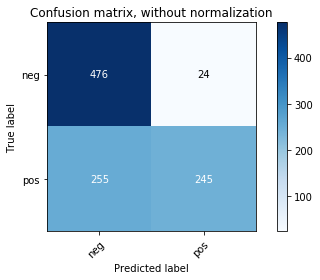

Accuracy:  0.721
Precision:  0.9107806691449815
Recall:  0.49


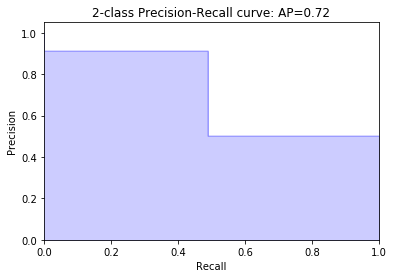

With 20% Holdout: 0.65
Testing on Sample: 0.721


In [12]:
# Reset
amazon_raw = pd.read_csv('./datasets/sentiment_labelled_sentences/amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['sent', 'score']
# find any keywords which are typically for each category 
keywords = ['Great', 
            'Excellent', 
            'excellent', 
            'good', 
            'Good', 
            'great', 
            'wast', 
            'Not Buy', 
            'poor', 
            'not work', 
            'disapoinment', 
            'glad', 
            'love', # helps
            #'recommend', precsion gets better, recall gets worse
            'perfect', # helps
            #'Unreliable', # is not helping
            #'unreliable', # is not helping
            'happy',
            'unhappy', # helps
            'best', # helps
            'excelent', # helps a tiny bit
            'Excelent', # helps a tiny bit
            'nice', # helps
            'fine'] # helps

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon_raw[str(key)] = amazon_raw.sent.str.contains(
        str(key),
        case=False
    )

amazon_data = amazon_raw[keywords]
amazon_target = amazon_raw['score']

# Instantiate our model and store it in a new variable.
from sklearn.naive_bayes import MultinomialNB
amazon_bnb = MultinomialNB()

# Fit our model to the data.
amazon_bnb.fit(amazon_data, amazon_target)

# Classify, storing the result in a new variable.
amazon_y_pred = amazon_bnb.predict(amazon_data)

plot_confusion_matrix(amazon_target, amazon_y_pred,  np.array(['neg', 'pos']))
plt.show()
print("Accuracy: ", accuracy_score(amazon_target, amazon_y_pred))
print("Precision: ", precision_score(amazon_target, amazon_y_pred))
print("Recall: ", recall_score(amazon_target, amazon_y_pred))


precision, recall, _ = precision_recall_curve(amazon_target, amazon_y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Test your model with different holdout groups.
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(amazon_data, amazon_target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(amazon_bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(amazon_bnb.fit(amazon_data, amazon_target).score(amazon_data, amazon_target)))

#### !!! MultinomialNB got even worse. GaussianNB had to impact. !!!

#### !!! With less keywords the holdout group model accuracy gets worse --> no overfitting yet !!!